In [193]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from network_v3 import *

# --------------------------------------------------
# Paths
# --------------------------------------------------
path = "/home/haltmayermarc/Samsung_ICML/data/P1_ne0.0625_Darcy_500_quantile.npz"
data = np.load(path, allow_pickle=True)

In [194]:
print(data["train_Q"].shape)
print(data["train_coeffs_a"].shape)
print(data["train_matrices"].shape)
print(data["train_load_vectors"].shape)
print(data["train_u"].shape)
print(data["train_u_h_fine"].shape)
print("----------------------")
print(data["validate_Q"].shape)
print(data["validate_coeffs_a"].shape)
print(data["validate_matrices"].shape)
print(data["validate_u"].shape)
print(data["validate_load_vectors"].shape)
print(data["validate_u_h_fine"].shape)

(0,)
(500, 129, 129)
(500, 225, 225)
(500, 225)
(500, 225)
(500, 16641)
----------------------
(100, 289, 16641)
(100, 129, 129)
(100, 225, 225)
(100, 225)
(100, 225)
(100, 16641)


In [195]:
validate_Q = data["validate_Q"]
validate_coeffs_a = data["validate_coeffs_a"]
validate_matrices = data["validate_matrices"]
validate_u_lod = data["validate_u"]
validate_load_vectors = data["validate_load_vectors"]
validate_u_h_fine = data["validate_u_h_fine"]

In [196]:
coeff_preproc = "log"

In [197]:
def compute_stats_with_preprocessor(chunk_size: int = 32):
    """Compute mean/std for the *preprocessed* input channels, and u mean/std.

    We compute stats using the exact same preprocessing module used in the model
    (DarcyInputPreprocess) to avoid any mismatch.
    """

    a_all = data["train_coeffs_a"].astype(np.float32)  
    u_all = data["train_u"].astype(np.float32)

    pre = DarcyInputPreprocess(
        coeff_preproc=coeff_preproc,
        add_grad=True,
        add_coords=True,
        default_hw=(a_all.shape[1], a_all.shape[2]),
    )
    Cin = pre.Cin

    sums = torch.zeros(Cin, dtype=torch.float64)
    sums2 = torch.zeros(Cin, dtype=torch.float64)
    count = 0

    for i in range(0, a_all.shape[0], chunk_size):
        a = torch.from_numpy(a_all[i:i + chunk_size])  # (B,H,W)
        x = pre(a)  # (B,C,H,W) on CPU
        # accumulate per-channel sums over pixels and batch
        sums += x.double().sum(dim=(0, 2, 3))
        sums2 += (x.double() ** 2).sum(dim=(0, 2, 3))
        count += int(x.shape[0] * x.shape[2] * x.shape[3])

    mean = (sums / count).float()  # (C,)
    var = (sums2 / count - (sums / count) ** 2).float()
    std = torch.sqrt(torch.clamp(var, min=1e-12)).float()

    u_mean = torch.from_numpy(u_all.mean(axis=0))
    u_std = torch.from_numpy(u_all.std(axis=0))

    return mean.view(Cin, 1, 1), std.view(Cin, 1, 1), u_mean, u_std

In [198]:
x_mean, x_std, u_mean, u_std = compute_stats_with_preprocessor()

model = build_darcy_coeff_model(
    model_name="LODMimetic",
    coeff_preproc=coeff_preproc,
    add_grad=True,
    add_coords=True,
    x_mean=x_mean,
    x_std=x_std,
    u_mean=u_mean,
    u_std=u_std,
    default_hw=(validate_coeffs_a.shape[1], validate_coeffs_a.shape[2]),
)

ckpt_path = "/home/haltmayermarc/Samsung_ICML/model/quantile/LODMimetic/LODMimetic_l1.pt"

#state_dict = torch.load(ckpt_path, map_location="cpu")
#model.load_state_dict(state_dict["model_state_dict"])

#state = torch.load(ckpt_path, map_location="cpu")["model_state_dict"]

# Clone the problematic tensors
#state["pre._xx_default"] = state["pre._xx_default"].clone()
#state["pre._yy_default"] = state["pre._yy_default"].clone()

#model.load_state_dict(state)

state = torch.load(ckpt_path, map_location="cpu")["model_state_dict"]

# Remove problematic keys
state.pop("pre._xx_default")
state.pop("pre._yy_default")

# Load everything else
model.load_state_dict(state, strict=False)

# Now overwrite safely
with torch.no_grad():
    model.pre._xx_default = model.pre._xx_default.clone()
    model.pre._yy_default = model.pre._yy_default.clone()

In [199]:
input_data = torch.tensor(validate_coeffs_a)

In [200]:
model.eval()
with torch.no_grad():
    u_pred = model(input_data)
u_pred = u_pred.squeeze().cpu().numpy()

In [201]:
u_pred.shape

(100, 225)

In [202]:
P_h = data["P_h"]
interior = [j * 17 + i for j in range(1, 16) for i in range(1, 16)]
error_sum = 0.0
error_sum1 = 0.0
u_fine_LOD_list = []

for i in range(validate_u_lod.shape[0]):
    num1 = np.linalg.norm(u_pred[i] - validate_u_lod[i])
    denom1 = np.linalg.norm(validate_u_lod[i])
    print("Rel L2 coefficient error:", num1/denom1)
    error_sum1 += num1/denom1
    u = np.zeros(289)
    u[interior] = u_pred[i]
    u_fine_LOD = (P_h + validate_Q[i]).T @ u
    u_fine_LOD_list.append(u_fine_LOD)
    num = np.linalg.norm(u_fine_LOD - validate_u_h_fine[i])
    denom = np.linalg.norm(validate_u_h_fine[i])
    print("Rel L2 u_pred_LOD_fine error:", num/denom) 
    print("#############################################################")
    error_sum += num/denom

print(error_sum1 / validate_u_lod.shape[0])
print(error_sum / validate_u_lod.shape[0])

Rel L2 coefficient error: 0.05356424675070822
Rel L2 u_pred_LOD_fine error: 0.13338584220745098
#############################################################
Rel L2 coefficient error: 0.02481019682682724
Rel L2 u_pred_LOD_fine error: 0.031497922662915165
#############################################################
Rel L2 coefficient error: 6.4153875203337325
Rel L2 u_pred_LOD_fine error: 6.444958071385362
#############################################################
Rel L2 coefficient error: 0.06770985911499042
Rel L2 u_pred_LOD_fine error: 0.09465494830874906
#############################################################
Rel L2 coefficient error: 0.028549744377226544
Rel L2 u_pred_LOD_fine error: 0.03980112548533913
#############################################################
Rel L2 coefficient error: 0.045366897329861856
Rel L2 u_pred_LOD_fine error: 0.04543455034137344
#############################################################
Rel L2 coefficient error: 0.04768283178040989
Rel L2

In [203]:
u_h_LOD = np.array(u_fine_LOD_list)

In [204]:
fine_nodes = data["fine_nodes"]
fine_elems = data["fine_elems"]

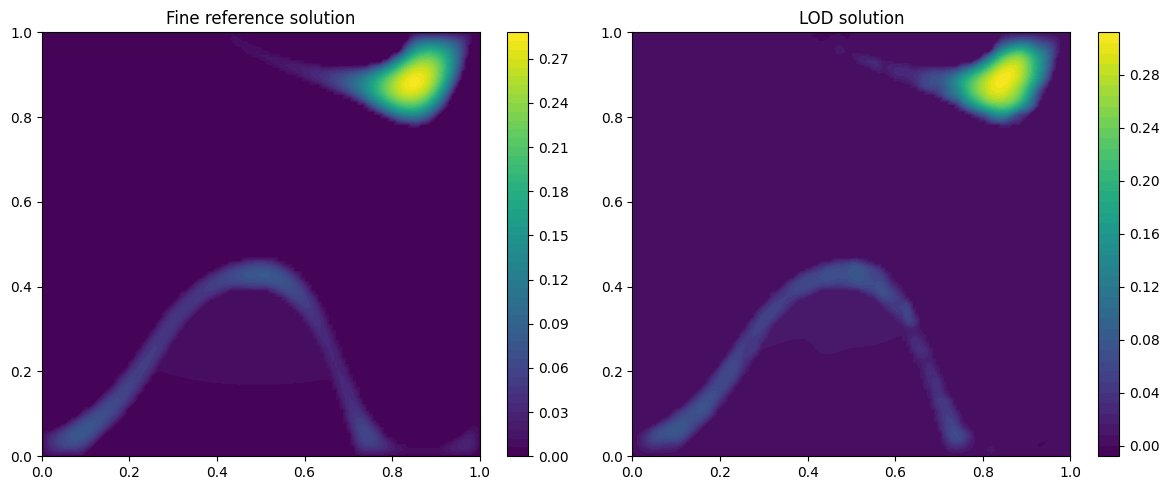

In [205]:
idx = -3
import matplotlib.tri as mtri

tri = mtri.Triangulation(
    fine_nodes[:,0],
    fine_nodes[:,1],
    fine_elems
)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.tricontourf(tri, validate_u_h_fine[idx], levels=50)
plt.colorbar()
plt.title("Fine reference solution")

plt.subplot(1,2,2)
plt.tricontourf(tri, u_h_LOD[idx], levels=50)
plt.colorbar()
plt.title("LOD solution")

plt.tight_layout()
plt.show()

In [206]:
np.linalg.norm(u_h_LOD[idx] - validate_u_h_fine[idx]) / np.linalg.norm(validate_u_h_fine[idx])

np.float64(0.12021723940515706)